In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm

2023-05-18 02:10:47.966841: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 02:10:48.071260: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-18 02:10:48.490367: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/andres/installROOT/lib
2023-05-18 02:10:48.490446: W tensorflow/compiler/xla/stre

In [2]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
!pip install xgboost

import xgboost
from xgboost import XGBRegressor, XGBClassifier

In [4]:
import h5py

import glob
import numpy as np
import os.path as path
import imageio
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime
import keras
from keras import regularizers
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, precision_recall_curve, auc,recall_score
from keras.optimizers import Adam
from keras.regularizers import l2
import h5py
from sklearn.model_selection import GridSearchCV
from keras.backend import cast, greater, clip, floatx,epsilon
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from sklearn.model_selection import StratifiedKFold

### Load Data

In [5]:
filefolder = '../../data2024/processed/'

###################
# BACKGROUND FILE #
###################

filename_B = 'ER/ER_all.hdf5'


###############
# SIGNAL FILE #
###############

# select the DM mass
mDM = 50

filename_S = 'mDM' + str(mDM) + 'GeV/WP_mDM' + str(mDM) + 'GeV_sig1045.hdf5'

In [6]:
# OPEN THE SAVED FILE TO CHECK IT
f_B = h5py.File(filefolder+filename_B,'r')
f_S = h5py.File(filefolder+filename_S,'r')

# show the groups
print( f_B.keys() )

# should be more than 10k events in each group
print('\n Background Events: ')
for groups1 in f_B.keys():
    print(len(f_B[groups1].keys()))

print('\n Signal Events')
for groups1 in f_S.keys():
    print(len(f_S[groups1].keys()))

<KeysViewHDF5 ['HITS_bot', 'HITS_bot_img', 'HITS_top', 'HITS_top_img', 'peakS1_onlyhits', 'peakS1_raw', 'peakS2_onlyhits', 'peakS2_raw']>

 Background Events: 
17206
17206
17206
17206
17206
17206
17206
17206

 Signal Events
12157
12157
12157
12157
12157
12157
12157
12157


In [7]:
################
# ALL THE DATA #
################


# to normalize
scaler = preprocessing.MinMaxScaler()

# Number of data points (per-class) for the ML classifier
num_data = 10000


############
# HITS_bot #
############

hits_bot_B = np.array( f_B['HITS_bot/ev_1'] )
hits_bot_S = np.array( f_S['HITS_bot/ev_1'] )

print('hits_bot length: ', len(hits_bot_S))


for i in range(2,num_data+1):
    # add new event to the matrix as a row
    hits_bot_B = np.row_stack([hits_bot_B,np.array( f_B['HITS_bot/ev_'+str(i)] )])
    hits_bot_S = np.row_stack([hits_bot_S,np.array( f_S['HITS_bot/ev_'+str(i)] )])



# X and Y for the classifier
X_hits_bot = np.row_stack([hits_bot_B,hits_bot_S])
# normalize
X_hits_bot = scaler.fit_transform(X_hits_bot)

del hits_bot_B
del hits_bot_S



############
# HITS_top #
############

hits_top_B = np.array( f_B['HITS_top/ev_1'] )
hits_top_S = np.array( f_S['HITS_top/ev_1'] )

print('hits_top length: ', len(hits_top_S))


for i in range(2,num_data+1):
    # add new event to the matrix as a row
    hits_top_B = np.row_stack([hits_top_B,np.array( f_B['HITS_top/ev_'+str(i)] )])
    hits_top_S = np.row_stack([hits_top_S,np.array( f_S['HITS_top/ev_'+str(i)] )])



# X and Y for the classifier
X_hits_top = np.row_stack([hits_top_B,hits_top_S])
# normalize
X_hits_top = scaler.fit_transform(X_hits_top)

del hits_top_B
del hits_top_S



###################
# peakS1_onlyhits #
###################

# First:
# The max len for the time series

max_pS1_B = 0
max_pS1_S = 0

for i in range(1, num_data+1):
    max_pS1_B = max(max_pS1_B, len( f_B['peakS1_onlyhits/ev_'+str(i)] ))
    max_pS1_S = max(max_pS1_S, len( f_S['peakS1_onlyhits/ev_'+str(i)] ))
    
    
max_pS1_both = max(max_pS1_B,max_pS1_S)

print('max_pS1_both lenght: ', max_pS1_both)



# Second:
# add the events in a matrix, but all with the same length -> fill with zeros

# how many elements do we need to make all the peak (S1 or S2) arrays with the same length
diff_elem_S1_B = max_pS1_both - len( f_B['peakS1_onlyhits/ev_1'][()] )
diff_elem_S1_S = max_pS1_both - len( f_S['peakS1_onlyhits/ev_1'][()] )

# add zeros at the end
peakS1_onlyhits_B = np.pad(f_B['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_B), 'constant')
peakS1_onlyhits_S = np.pad(f_S['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_S), 'constant')

for i in range(2, num_data+1):
    
    # how many elements do we need to make all the peak (S1 or S2) arrays with the same length
    diff_elem_S1_B = max_pS1_both - len( f_B['peakS1_onlyhits/ev_'+str(i)][()] )
    diff_elem_S1_S = max_pS1_both - len( f_S['peakS1_onlyhits/ev_'+str(i)][()] )
    
    # add zeros at the end
    aux_S1_B = np.pad(f_B['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_B), 'constant')
    aux_S1_S = np.pad(f_S['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_S), 'constant')
    
    # add new event to the matrix as a row
    peakS1_onlyhits_B = np.row_stack([peakS1_onlyhits_B,aux_S1_B])
    peakS1_onlyhits_S = np.row_stack([peakS1_onlyhits_S,aux_S1_S])
    
    
    

# X and Y for the classifier
X_peakS1 = np.row_stack([peakS1_onlyhits_B,peakS1_onlyhits_S])
# normalize
X_peakS1 = scaler.fit_transform(X_peakS1)

del peakS1_onlyhits_B
del peakS1_onlyhits_S




###################
# peakS2_onlyhits #
###################

# First:
# The max len for the time series

max_pS2_B = 0
max_pS2_S = 0

for i in range(1, num_data+1):
    max_pS2_B = max(max_pS2_B, len( f_B['peakS2_onlyhits/ev_'+str(i)] ))
    max_pS2_S = max(max_pS2_S, len( f_S['peakS2_onlyhits/ev_'+str(i)] ))
    
    
max_pS2_both = max(max_pS2_B,max_pS2_S)

print('max_pS2_both lenght: ', max_pS2_both)



# Second:
# add the events in a matrix, but all with the same length -> fill with zeros

# how many elements do we need to make all the peak (S2 or S2) arrays with the same length
diff_elem_S2_B = max_pS2_both - len( f_B['peakS2_onlyhits/ev_1'][()] )
diff_elem_S2_S = max_pS2_both - len( f_S['peakS2_onlyhits/ev_1'][()] )

# add zeros at the end
peakS2_onlyhits_B = np.pad(f_B['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_B), 'constant')
peakS2_onlyhits_S = np.pad(f_S['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_S), 'constant')

for i in range(2, num_data+1):
    
    # how many elements do we need to make all the peak (S2 or S2) arrays with the same length
    diff_elem_S2_B = max_pS2_both - len( f_B['peakS2_onlyhits/ev_'+str(i)][()] )
    diff_elem_S2_S = max_pS2_both - len( f_S['peakS2_onlyhits/ev_'+str(i)][()] )
    
    # add zeros at the end
    aux_S2_B = np.pad(f_B['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_B), 'constant')
    aux_S2_S = np.pad(f_S['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_S), 'constant')
    
    # add new event to the matrix as a row
    peakS2_onlyhits_B = np.row_stack([peakS2_onlyhits_B,aux_S2_B])
    peakS2_onlyhits_S = np.row_stack([peakS2_onlyhits_S,aux_S2_S])
    
    
    

# X and Y for the classifier
X_peakS2 = np.row_stack([peakS2_onlyhits_B,peakS2_onlyhits_S])
# normalize
X_peakS2 = scaler.fit_transform(X_peakS2)

del peakS2_onlyhits_B
del peakS2_onlyhits_S



# close the h5 files
f_B.close()
f_S.close()





###################
# CONCATENATE ALL #
###################

X_mon = np.concatenate([X_hits_bot,X_hits_top,X_peakS1,X_peakS2],axis=1)

del X_hits_bot
del X_hits_top
del X_peakS1
del X_peakS2

# labels
y_mon = np.concatenate([np.zeros(num_data),np.ones(num_data)])


# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon_aux, X_mon_test, y_mon_aux, y_mon_test = train_test_split(X_mon,
                                                                y_mon,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon,
                                                                shuffle=True)

del X_mon
del y_mon

X_mon_train, X_mon_val, y_mon_train, y_mon_val = train_test_split(X_mon_aux,
                                                                  y_mon_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon_aux,
                                                                  shuffle=True)

del X_mon_aux
del y_mon_aux

print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')

hits_bot length:  121
hits_top length:  127
max_pS1_both lenght:  169
max_pS2_both lenght:  2244

X_mon_train :  (9999, 2661)
y_mon_train :  (9999,)
X_mon_val :  (3334, 2661)
y_mon_val :  (3334,)
X_mon_test :  (6667, 2661)
y_mon_test :  (6667,)



### CLASSIFIER

/home/andres/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/andres/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.11641	validation_0-logloss:0.63120	validation_0-map:0.90865	validation_1-error:0.13827	validation_1-logloss:0.63470	validation_1-map:0.89401
[1]	validation_0-error:0.10661	validation_0-logloss:0.57979	validation_0-map:0.92023	validation_1-error:0.13017	validation_1-logloss:0.58706	validation_1-map:0.91315
[2]	validation_0-error:0.10421	validation_0-logloss:0.53585	validation_0-map:0.93657	validation_1-error:0.12807	validation_1-logloss:0.54668	validation_1-map:0.92311
[3]	validation_0-error:0.09781	validation_0-logloss:0.49877	validation_0-map:0.94763	validation_1-error:0.12657	validation_1-logloss:0.51332	validation_1-map:0.92751
[4]	validation_0-error:0.09431	validation_0-logloss:0.46650	validation_0-map:0.95492	validation_1-error:0.12388	validation_1-logloss:0.48430	validation_1-map:0.93195
[5]	validation_0-error:0.09051	validation_0-logloss:0.43778	validation_0-map:0.95730	validation_1-error:0.11788	validation_1-logloss:0.45880	validation_1-map:0.93433
[6]	

[50]	validation_0-error:0.03490	validation_0-logloss:0.12677	validation_0-map:0.99572	validation_1-error:0.09418	validation_1-logloss:0.23788	validation_1-map:0.96119
[51]	validation_0-error:0.03430	validation_0-logloss:0.12529	validation_0-map:0.99588	validation_1-error:0.09328	validation_1-logloss:0.23729	validation_1-map:0.96143
[52]	validation_0-error:0.03280	validation_0-logloss:0.12338	validation_0-map:0.99609	validation_1-error:0.09298	validation_1-logloss:0.23682	validation_1-map:0.96171
[53]	validation_0-error:0.03130	validation_0-logloss:0.12123	validation_0-map:0.99632	validation_1-error:0.09268	validation_1-logloss:0.23651	validation_1-map:0.96165
[54]	validation_0-error:0.03080	validation_0-logloss:0.12002	validation_0-map:0.99640	validation_1-error:0.09298	validation_1-logloss:0.23616	validation_1-map:0.96162
[55]	validation_0-error:0.03040	validation_0-logloss:0.11804	validation_0-map:0.99664	validation_1-error:0.09118	validation_1-logloss:0.23619	validation_1-map:0.9614

[100]	validation_0-error:0.00980	validation_0-logloss:0.07170	validation_0-map:0.99965	validation_1-error:0.08998	validation_1-logloss:0.22692	validation_1-map:0.96489
[101]	validation_0-error:0.00970	validation_0-logloss:0.07109	validation_0-map:0.99967	validation_1-error:0.09028	validation_1-logloss:0.22702	validation_1-map:0.96497
[102]	validation_0-error:0.00910	validation_0-logloss:0.07041	validation_0-map:0.99969	validation_1-error:0.08938	validation_1-logloss:0.22704	validation_1-map:0.96484
[103]	validation_0-error:0.00850	validation_0-logloss:0.06995	validation_0-map:0.99970	validation_1-error:0.08968	validation_1-logloss:0.22729	validation_1-map:0.96487
[104]	validation_0-error:0.00890	validation_0-logloss:0.06930	validation_0-map:0.99971	validation_1-error:0.08908	validation_1-logloss:0.22730	validation_1-map:0.96491
[105]	validation_0-error:0.00840	validation_0-logloss:0.06867	validation_0-map:0.99973	validation_1-error:0.08998	validation_1-logloss:0.22722	validation_1-map:

[149]	validation_0-error:0.00210	validation_0-logloss:0.04693	validation_0-map:0.99999	validation_1-error:0.09088	validation_1-logloss:0.22930	validation_1-map:0.96557
[150]	validation_0-error:0.00190	validation_0-logloss:0.04622	validation_0-map:0.99999	validation_1-error:0.09088	validation_1-logloss:0.22954	validation_1-map:0.96558
[151]	validation_0-error:0.00190	validation_0-logloss:0.04573	validation_0-map:0.99999	validation_1-error:0.09178	validation_1-logloss:0.22961	validation_1-map:0.96561
[152]	validation_0-error:0.00200	validation_0-logloss:0.04515	validation_0-map:0.99999	validation_1-error:0.09178	validation_1-logloss:0.22996	validation_1-map:0.96551
[153]	validation_0-error:0.00200	validation_0-logloss:0.04490	validation_0-map:0.99999	validation_1-error:0.09088	validation_1-logloss:0.22983	validation_1-map:0.96559
[154]	validation_0-error:0.00140	validation_0-logloss:0.04439	validation_0-map:0.99999	validation_1-error:0.09088	validation_1-logloss:0.23003	validation_1-map:

[198]	validation_0-error:0.00020	validation_0-logloss:0.03251	validation_0-map:1.00000	validation_1-error:0.09208	validation_1-logloss:0.23326	validation_1-map:0.96606
[199]	validation_0-error:0.00020	validation_0-logloss:0.03218	validation_0-map:1.00000	validation_1-error:0.09088	validation_1-logloss:0.23355	validation_1-map:0.96606
[200]	validation_0-error:0.00010	validation_0-logloss:0.03190	validation_0-map:1.00000	validation_1-error:0.09148	validation_1-logloss:0.23334	validation_1-map:0.96630
[201]	validation_0-error:0.00010	validation_0-logloss:0.03153	validation_0-map:1.00000	validation_1-error:0.09118	validation_1-logloss:0.23362	validation_1-map:0.96626
[202]	validation_0-error:0.00010	validation_0-logloss:0.03135	validation_0-map:1.00000	validation_1-error:0.09148	validation_1-logloss:0.23353	validation_1-map:0.96628
[203]	validation_0-error:0.00010	validation_0-logloss:0.03105	validation_0-map:1.00000	validation_1-error:0.09088	validation_1-logloss:0.23362	validation_1-map:

[247]	validation_0-error:0.00000	validation_0-logloss:0.02189	validation_0-map:1.00000	validation_1-error:0.09118	validation_1-logloss:0.23848	validation_1-map:0.96664
[248]	validation_0-error:0.00000	validation_0-logloss:0.02183	validation_0-map:1.00000	validation_1-error:0.09088	validation_1-logloss:0.23848	validation_1-map:0.96666
[249]	validation_0-error:0.00000	validation_0-logloss:0.02177	validation_0-map:1.00000	validation_1-error:0.09088	validation_1-logloss:0.23858	validation_1-map:0.96664
[250]	validation_0-error:0.00000	validation_0-logloss:0.02171	validation_0-map:1.00000	validation_1-error:0.09118	validation_1-logloss:0.23873	validation_1-map:0.96657
[251]	validation_0-error:0.00000	validation_0-logloss:0.02159	validation_0-map:1.00000	validation_1-error:0.09118	validation_1-logloss:0.23905	validation_1-map:0.96655
[252]	validation_0-error:0.00000	validation_0-logloss:0.02144	validation_0-map:1.00000	validation_1-error:0.09118	validation_1-logloss:0.23925	validation_1-map:

[296]	validation_0-error:0.00000	validation_0-logloss:0.01537	validation_0-map:1.00000	validation_1-error:0.08908	validation_1-logloss:0.24596	validation_1-map:0.96651
[297]	validation_0-error:0.00000	validation_0-logloss:0.01531	validation_0-map:1.00000	validation_1-error:0.08908	validation_1-logloss:0.24607	validation_1-map:0.96647


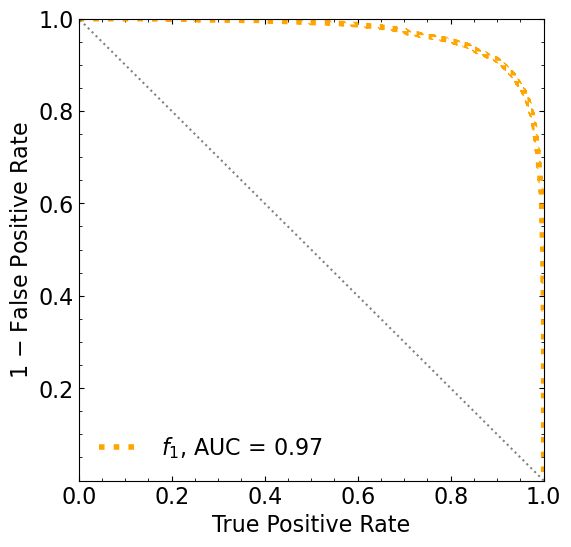

In [8]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5)

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        eval_metric=["error", "logloss", "map"],early_stopping_rounds=50,#early stopping
        verbose=True)

# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()

In [9]:
roc_auc_xg

0.9673041496012751

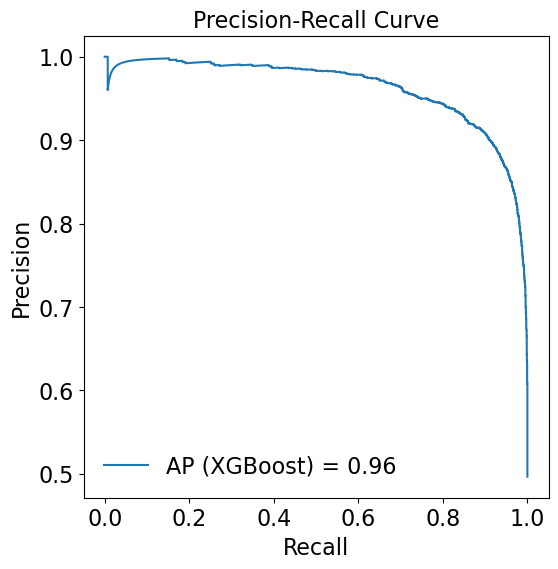

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, precision_recall_curve

precision_xg, recall_xg, _ = precision_recall_curve(y_mon_test, y_pred_xg)
auc_xg = auc(recall_xg, precision_xg)

plt.figure(figsize=(6, 6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(recall_xg, precision_xg, label=f'AP (XGBoost) = {auc_xg:.2f}')
plt.title('Precision-Recall Curve', size=16)
plt.xlabel('Recall', size=16)
plt.ylabel('Precision', size=16)
plt.legend(frameon=False,fontsize=16)
plt.show()

In [11]:
auc_xg

0.9632101175359027

Accuracy: 90.67%


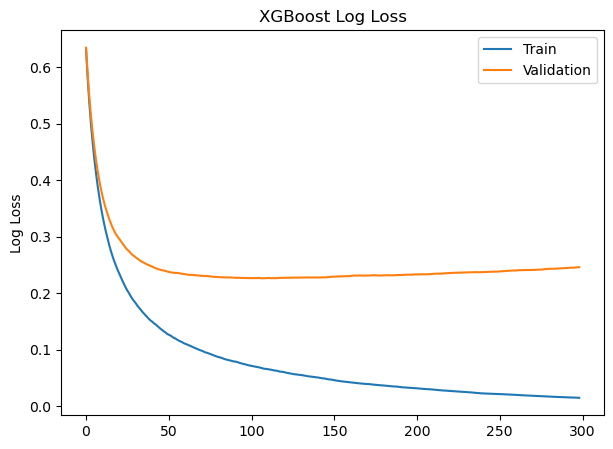

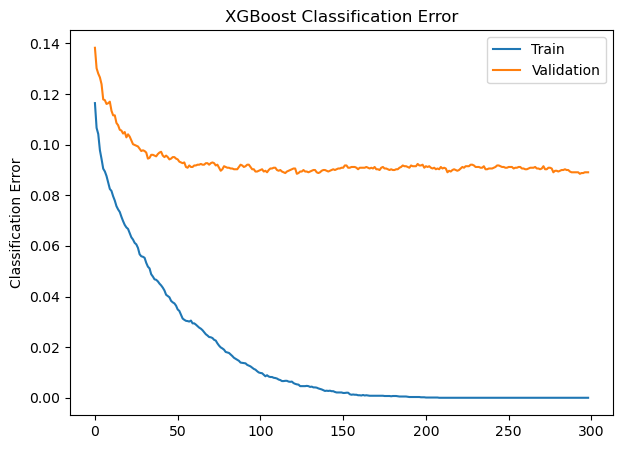

In [12]:
predictions = [round(value) for value in y_pred_xg]
accuracy = accuracy_score(y_mon_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

results = classifier.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)


# plot log loss
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], label="Validation")
ax.legend()
plt.ylabel("Log Loss")
plt.title("XGBoost Log Loss")
plt.show()

# plot classification error
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x_axis, results["validation_0"]["error"], label="Train")
ax.plot(x_axis, results["validation_1"]["error"], label="Validation")
ax.legend()
plt.ylabel("Classification Error")
plt.title("XGBoost Classification Error")
plt.show()

Classification score:


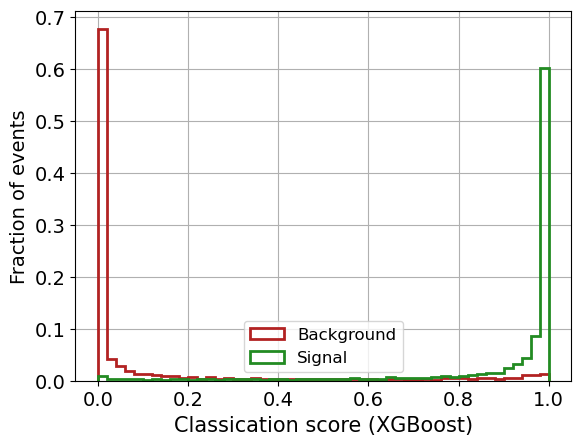

In [13]:
# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()